# Two-Region Slab Problem w/ Two Energy Group Flux Tallies

Setup python

In [19]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

import openmc
from openmc.statepoint import StatePoint

%matplotlib inline

## Load some nuclides

In [20]:
h1 = openmc.Nuclide('H-1')
o16 = openmc.Nuclide('O-16')
u235 = openmc.Nuclide('U-235')
u238 = openmc.Nuclide('U-238')

## Create fuel and moderator materials

In [21]:
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)
fuel.add_nuclide(h1, 9.2000e-2)

mod = openmc.Material(name='Moderator')
mod.set_density('g/cm3', 1.5)
mod.add_nuclide(o16,2.5000e-3)
mod.add_nuclide(h1, 5.0000e-3)

## Create materials object and export

In [22]:
materials_file = openmc.MaterialsFile()
materials_file.add_material(fuel)
materials_file.add_material(mod)
materials_file.default_xs = '71c'

materials_file.export_to_xml()

## Create surfaces

In [23]:
left = openmc.XPlane(x0=-10.0, boundary_type='vacuum')
internal_left = openmc.XPlane(x0=-8.0)
internal_right = openmc.XPlane(x0=+8.0)
right = openmc.XPlane(x0=+10.0, boundary_type='vacuum')
min_y = openmc.YPlane(y0=-1.0, boundary_type='reflective')
max_y = openmc.YPlane(y0=+1.0, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-1.0, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+1.0, boundary_type='reflective')

## Create cells

In [24]:
# Create a Universe to encapsulate a slab
slab_cell_universe = openmc.Universe(name='Slab')

# Create left moderator
mod_left_cell = openmc.Cell(name='Left Moderator')
mod_left_cell.fill = mod
mod_left_cell.region = +left & -internal_left
slab_cell_universe.add_cell(mod_left_cell)

# Create fuel
fuel_cell = openmc.Cell(name='Fuel')
fuel_cell.fill = fuel
fuel_cell.region = +internal_left & -internal_right
slab_cell_universe.add_cell(fuel_cell)

# Create right moderator
mod_right_cell = openmc.Cell(name='Right Moderator')
mod_right_cell.fill = mod
mod_right_cell.region = +internal_right & -right
slab_cell_universe.add_cell(mod_right_cell)

## Create root cell and geometry

In [25]:
root_cell = openmc.Cell(name='root cell')
root_cell.fill = slab_cell_universe

# Add boundary planes
root_cell.region = +left & -right & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

## Create geometry file and export

In [26]:
geometry_file = openmc.GeometryFile()
geometry_file.geometry = geometry

geometry_file.export_to_xml()

## Set OpenMC settings and export file

In [53]:
# OpenMC simulation parameters
batches = 100
inactive = 10
particles = 10000

# Instantiate a SettingsFile
settings_file = openmc.SettingsFile()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
source_bounds = [left.x0, min_y.y0, min_z.z0, right.x0, max_y.y0, max_z.z0]
settings_file.set_source_space('box', source_bounds)

# Export to "settings.xml"
settings_file.export_to_xml()

## Plot geometry

In [65]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'slab_geometry'
plot.origin = [0, 0, 0]
plot.width = [20.0, 2.0]
plot.pixels = [2000, 200]
plot.color = 'mat'
plot.col_spec={mod.id: (0, 184, 245), fuel.id:(255, 0, 0)}

# Instantiate a PlotsFile, add Plot, and export to "plots.xml"
plot_file = openmc.PlotsFile()
plot_file.add_plot(plot)
plot_file.export_to_xml()

## Run OpenMC to create plot

In [66]:
executor = openmc.Executor()
executor.plot_geometry(output=False)

0

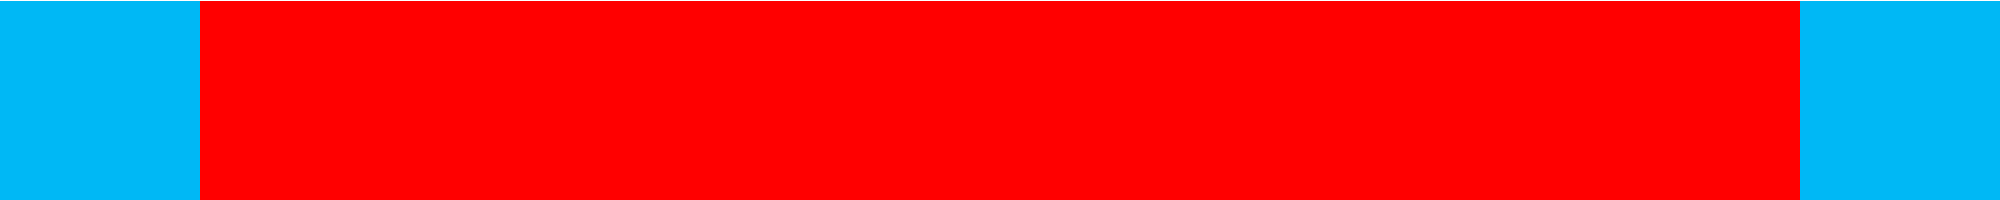

In [67]:
# Convert OpenMC's ppm to png
!convert slab_geometry.ppm slab_geometry.png

# Display the materials plot inline
Image(filename='slab_geometry.png')

## Create tallies

In [48]:
# Instantiate an empty TalliesFile
tallies_file = openmc.TalliesFile()

# Create mesh which will be used for tally
mesh = openmc.Mesh()
mesh.dimension = [200, 1]
mesh.lower_left = [left.x0, min_y.y0]
mesh.upper_right = [right.x0, max_y.y0]
tallies_file.add_mesh(mesh)

# Create mesh filter for tally
mesh_filter = openmc.Filter(type='mesh', bins=[1])
mesh_filter.mesh = mesh

# Create energy filter for tally
energy_filter = openmc.Filter(type='energy', bins=[0.0, 0.625e-6, 20.0])

# Create mesh tally to score flux and fission rate
tally_flux = openmc.Tally(name='flux')
tally_flux.add_filter(mesh_filter)
tally_flux.add_filter(energy_filter)
tally_flux.add_score('flux')
tallies_file.add_tally(tally_flux)

tally_fission = openmc.Tally(name='fission')
tally_fission.add_filter(mesh_filter)
tally_fission.add_score('fission')
tallies_file.add_tally(tally_fission)

# Export to "tallies.xml"
tallies_file.export_to_xml()

## Run OpenMC Simulation

In [49]:
executor.run_simulation()


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2015 Massachusetts Institute of Technology
      License:        http://mit-crpg.github.io/openmc/license.html
      Version:        0.7.0
      Git SHA1:       8f2b7b02fc7b7225f32ffd022c5fc9280e1380a5
      Date/Time:      2015-12-04 23:16:02
      MPI Processes:  1
      OpenMP Threads: 8



0

## Extract tallies

In [72]:
# Load the statepoint file
sp = StatePoint('statepoint.100.h5')

# Extract tallies from file
flux = sp.get_tally(scores=['flux'])
fission = sp.get_tally(scores=['fission'])

sp.close()

# Reshape
flux.mean.shape = (200, 2)
fission.mean.shape = (200,)

## Plot flux

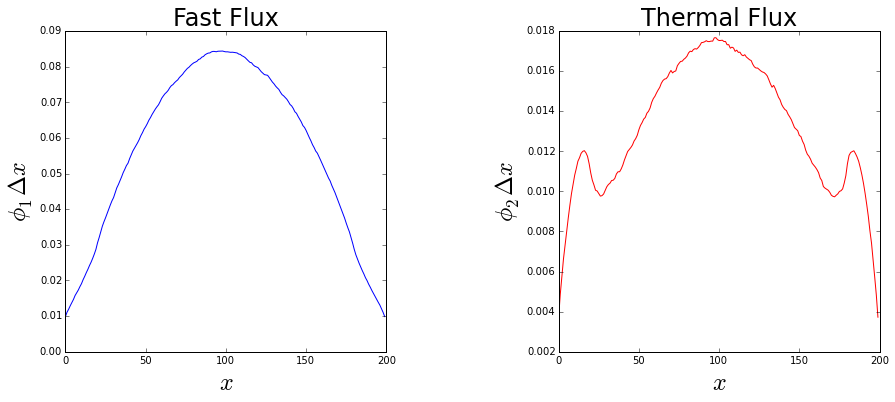

In [73]:
# Fast flux
plt.figure(figsize=(15,15))
fig=plt.subplot(121, adjustable='box', aspect=200/0.09)
fig.plot(flux.mean[:,1], 'b-')
fig.set_xlabel("$x$", fontsize=24)
fig.set_ylabel("$\phi_1\Delta x$", fontsize=24)
fig.set_title("Fast Flux", fontsize=24)

# Thermal flux
fig=plt.subplot(122, adjustable='box', aspect=200/0.016)
fig.plot(flux.mean[:,0], 'r-')
fig.set_xlabel("$x$", fontsize=24)
fig.set_ylabel("$\phi_2\Delta x$", fontsize=24)
fig.set_title("Thermal Flux", fontsize=24)

plt.tight_layout(pad=10)

## Plot fission rate

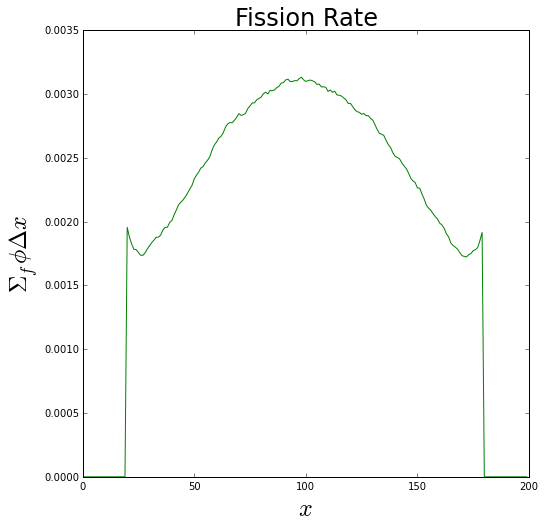

In [74]:
plt.figure(figsize=(8,8))
fig=plt.subplot(111, adjustable='box', aspect=200/0.0035)
fig.plot(fission.mean, 'g-')
fig.set_xlabel("$x$", fontsize=24)
fig.set_ylabel("$\Sigma_f\phi\Delta x$", fontsize=24)
fig.set_title("Fission Rate", fontsize=24)